In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
logs = torch.load('../logs_vanilla_sae/vanilla_sae_results.pt')
logs2 = torch.load('../logs_vanilla_sae/vanilla_sae_results_reanim.pt')

/tmp/ipykernel_3212590/3020457891.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs = torch.load('../logs_vanilla_sae/vanilla_sae_results.pt')
/tmp/ipykernel_3212590/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
import seaborn as sns

def plotter(logs, log_type):
    """
    Plot training metrics across epochs for different models with improved styling
    
    Args:
        logs: Dictionary with model names as keys and model logs as values
        log_type: Type of log to plot (e.g., 'loss', 'accuracy', etc.)
    """
    # Set style for better looking plots
    plt.style.use('seaborn-v0_8')  # Use seaborn style if available
    
    # Create figure with larger size
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color palette for different models
    colors = plt.cm.Set1(np.linspace(0, 1, len(logs)))
    
    # Plot each model
    for i, (model, model_logs) in enumerate(logs.items()):
        avg_loss = model_logs[log_type]
        epochs = list(range(1, len(avg_loss) + 1))
        
        # Plot with enhanced styling
        ax.plot(epochs, avg_loss, 
               label=model, 
               linewidth=2.5, 
               marker='o', 
               markersize=6,
               color=colors[i],
               alpha=0.8)
        
        # Add trend line only if loss has significant variation
        loss_range = max(avg_loss) - min(avg_loss)
        if len(epochs) > 3 and loss_range > 0.05:
            # Use exponential decay fit for better loss curve modeling
            try:
                from scipy.optimize import curve_fit
                
                def exp_decay(x, a, b, c):
                    return a * np.exp(-b * x) + c
                
                # Fit exponential decay
                popt, _ = curve_fit(exp_decay, epochs, avg_loss, 
                                  bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
                trend_y = exp_decay(np.array(epochs), *popt)
                
                ax.plot(epochs, trend_y, 
                       color=colors[i], 
                       linestyle='--', 
                       alpha=0.5, 
                       linewidth=1.5)
            except:
                # Fallback: Use moving average for smoothing
                if len(avg_loss) >= 5:
                    window = min(5, len(avg_loss) // 3)
                    smooth_loss = np.convolve(avg_loss, np.ones(window)/window, mode='same')
                    ax.plot(epochs, smooth_loss, 
                           color=colors[i], 
                           linestyle='--', 
                           alpha=0.5, 
                           linewidth=1.5)
    
    # Customize axes
    ax.set_xlabel("Epoch", fontsize=14, fontweight='bold')
    ax.set_ylabel(f"{log_type.capitalize()}", fontsize=14, fontweight='bold')
    ax.set_title(f"Training {log_type.capitalize()} Across Epochs", 
                fontsize=16, fontweight='bold', pad=20)
    
    # Improve grid
    ax.grid(True, linestyle='-', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.3f}'))
    
    # Ensure integer ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Legend removed for cleaner visualization
    # ax.legend(loc='best', frameon=True, fancybox=True, shadow=True, 
    #          fontsize=12, framealpha=0.9)
    
    # Set background color
    ax.set_facecolor('#f8f9fa')
    
    # Adjust layout
    plt.tight_layout()
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#333333')
    
    plt.show()

# Alternative: More advanced version with additional features
def advanced_plotter(logs, log_type, save_path=None, figsize=(14, 10)):
    """
    Advanced plotting function with additional features
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[3, 1])
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(logs)))
    
    # Main plot
    for i, (model, model_logs) in enumerate(logs.items()):
        avg_loss = model_logs[log_type]
        epochs = list(range(1, len(avg_loss) + 1))
        
        # Main line plot
        ax1.plot(epochs, avg_loss, 
                label=model, 
                linewidth=3, 
                marker='o', 
                markersize=7,
                color=colors[i],
                alpha=0.9)
        
        # Fill area under curve for better visual impact
        ax1.fill_between(epochs, avg_loss, alpha=0.1, color=colors[i])
        
        # Add final value annotation
        final_loss = avg_loss[-1]
        ax1.annotate(f'{final_loss:.3f}', 
                    xy=(epochs[-1], final_loss), 
                    xytext=(10, 10), 
                    textcoords='offset points',
                    fontsize=10, 
                    fontweight='bold',
                    color=colors[i],
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor=colors[i], 
                             alpha=0.2))
    
    # Customize main plot
    ax1.set_ylabel(f"{log_type.capitalize()}", fontsize=14, fontweight='bold')
    ax1.set_title(f"Training {log_type.capitalize()} Progression", 
                 fontsize=16, fontweight='bold', pad=20)
    ax1.grid(True, linestyle='-', alpha=0.3)
    # ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax1.set_facecolor('#f8f9fa')
    
    # Second subplot: Loss improvement rate
    for i, (model, model_logs) in enumerate(logs.items()):
        avg_loss = model_logs[log_type]
        if len(avg_loss) > 1:
            # Calculate improvement rate (negative of derivative)
            improvement = [-1 * (avg_loss[j+1] - avg_loss[j]) for j in range(len(avg_loss)-1)]
            epochs_improvement = list(range(2, len(avg_loss) + 1))
            
            ax2.plot(epochs_improvement, improvement, 
                    color=colors[i], 
                    linewidth=2, 
                    alpha=0.7,
                    label=f'{model} improvement')
    
    # Customize improvement plot
    ax2.set_xlabel("Epoch", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Loss Improvement", fontsize=12, fontweight='bold')
    ax2.set_title("Per-Epoch Loss Improvement", fontsize=14, fontweight='bold')
    ax2.grid(True, linestyle='-', alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_facecolor('#f8f9fa')
    
    # Format axes
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Simple, clean version
def clean_plotter(logs, log_type):
    """
    Clean, minimal version focused on clarity
    """
    plt.figure(figsize=(10, 6))
    
    # Use a clean color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    for i, (model, model_logs) in enumerate(logs.items()):
        avg_loss = model_logs[log_type]
        epochs = list(range(1, len(avg_loss) + 1))
        
        plt.plot(epochs, avg_loss, 
                label=model, 
                linewidth=2, 
                marker='o', 
                markersize=4,
                color=colors[i % len(colors)])
    
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(f"{log_type.capitalize()}", fontsize=12)
    plt.title(f"Training {log_type.capitalize()} vs Epochs", fontsize=14, fontweight='bold')
    # plt.legend(frameon=True, fancybox=True)  # Legend removed
    plt.grid(True, alpha=0.3)
    
    # Format y-axis to show more precision
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.4f}'))
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plotter(logs, 'loss')
# advanced_plotter(logs, 'loss', save_path='training_loss.png')
# clean_plotter(logs, 'loss')

## Vanilla SAE Without Reanimation Penalty

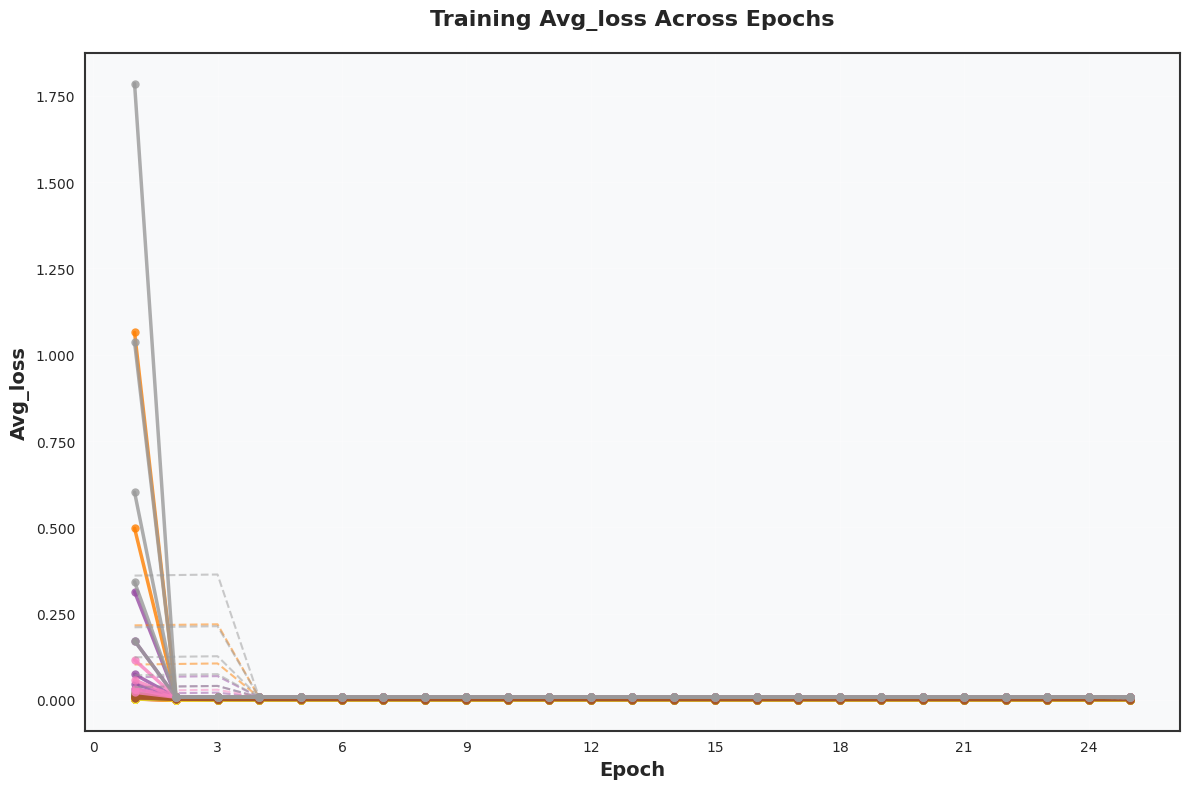

In [26]:
plotter(logs, 'avg_loss')

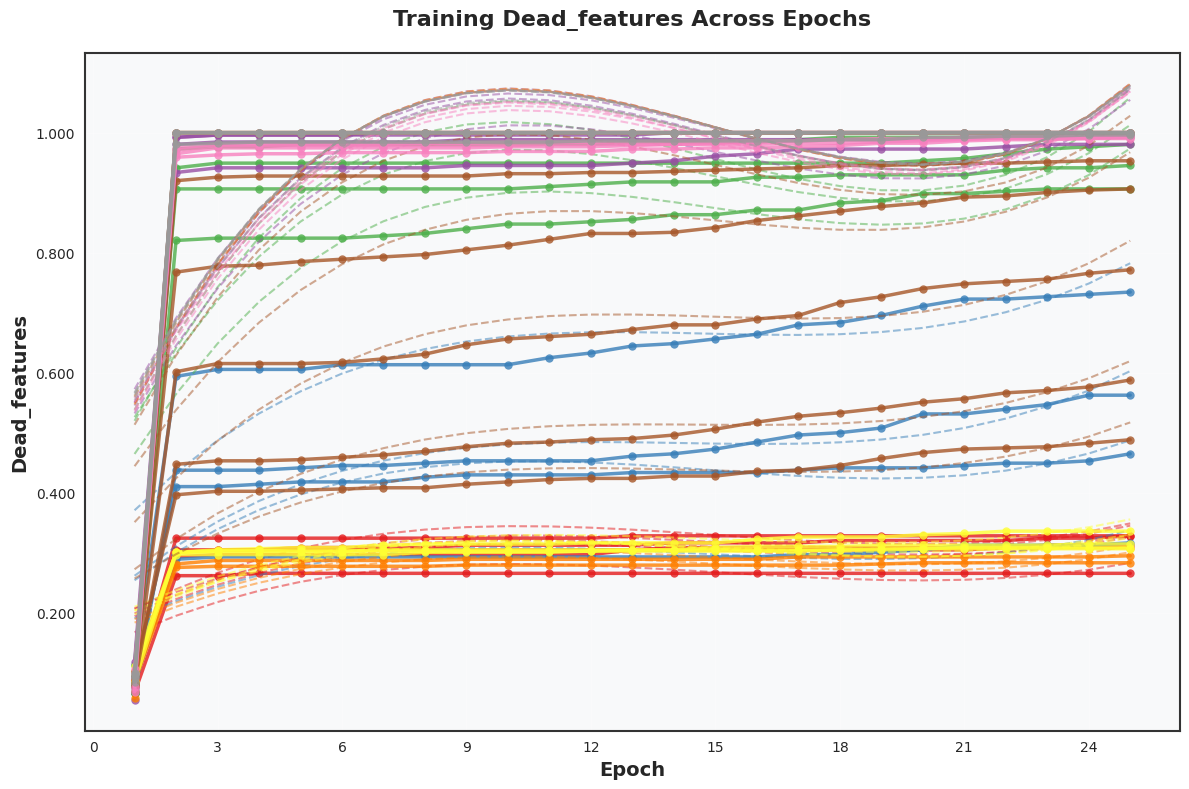

In [22]:
plotter(logs, 'dead_features')

## Vanilla SAE With Reanimate Penalty

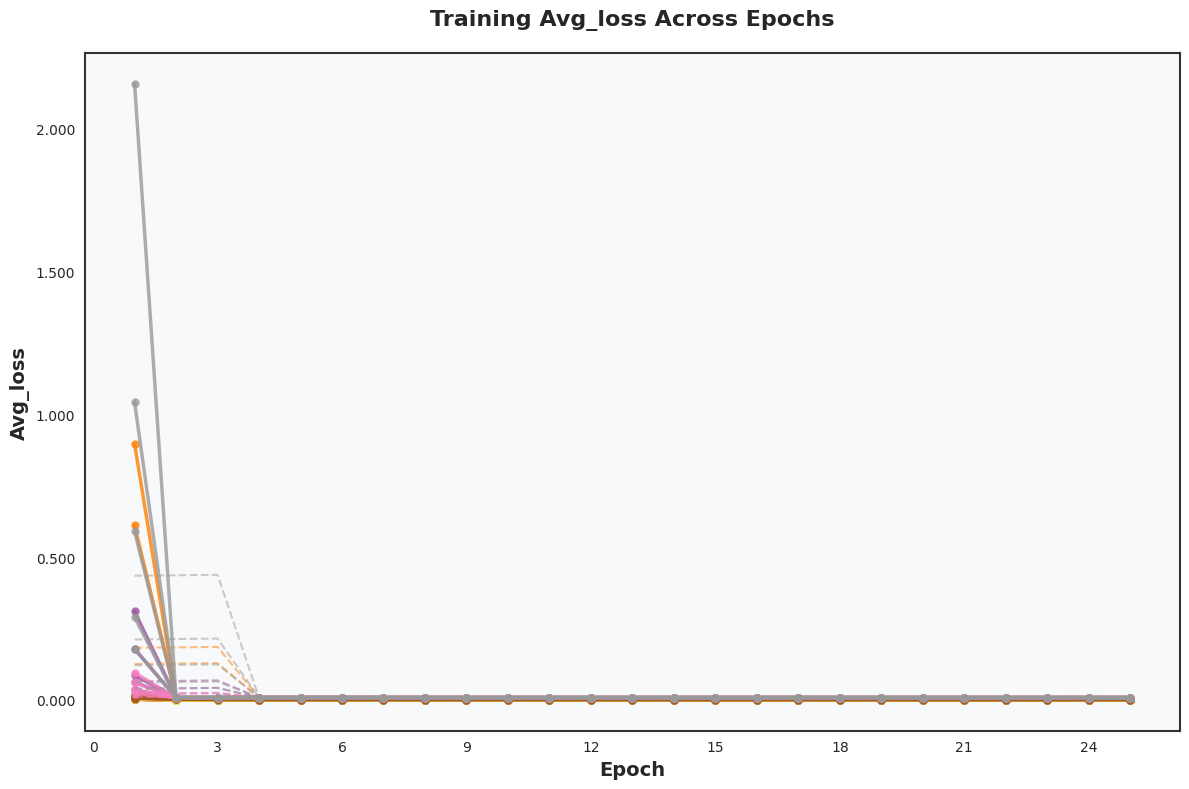

In [27]:
plotter(logs2, 'avg_loss')

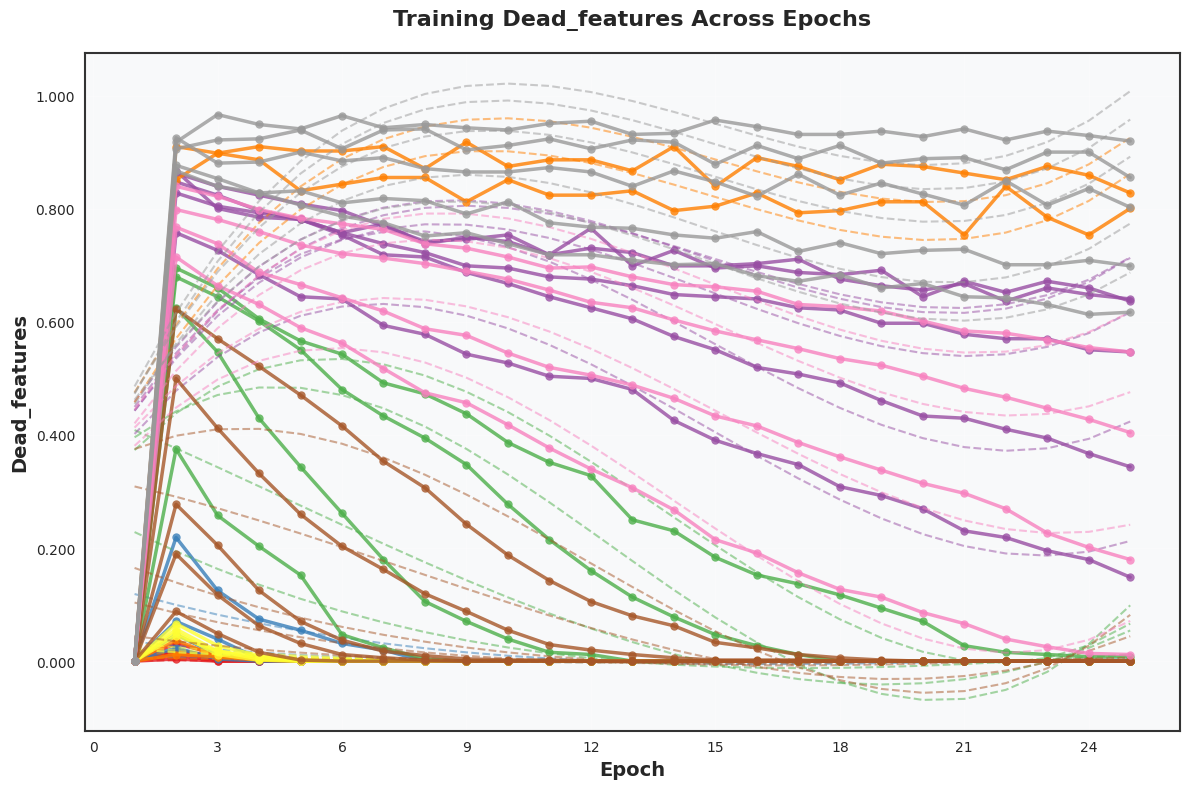

In [24]:
plotter(logs2, 'dead_features')

In [4]:
logs_topk = torch.load('../logs_topk_sae/top_k_sae_results.pt')
logs_topk_reanim = torch.load('../logs_topk_sae/top_k_sae_results_reanim.pt')

/tmp/ipykernel_3375568/182692672.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logs_topk = torch.load('../logs_topk_sae/top_k_sae_results.pt')
/tmp/ipykernel_3375568/1

## TOP K SAE Without Reanimate Penalty

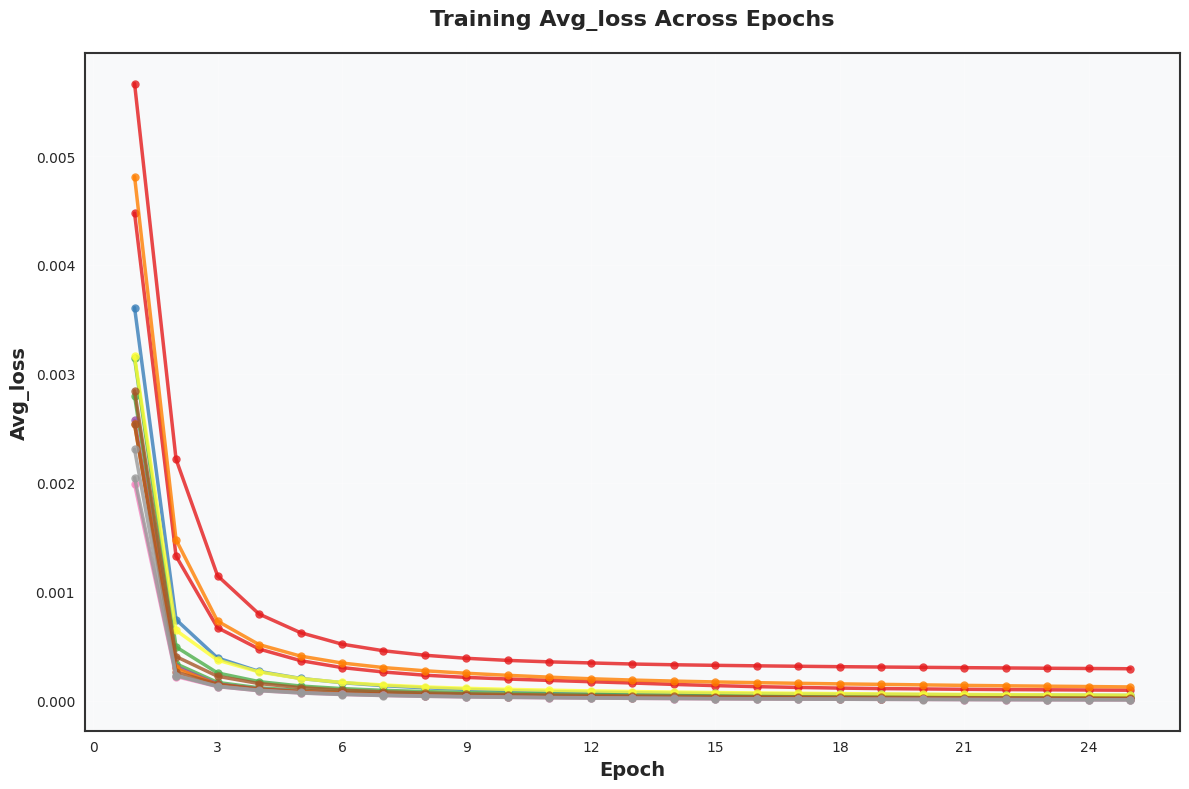

In [5]:
plotter(logs_topk, 'avg_loss')

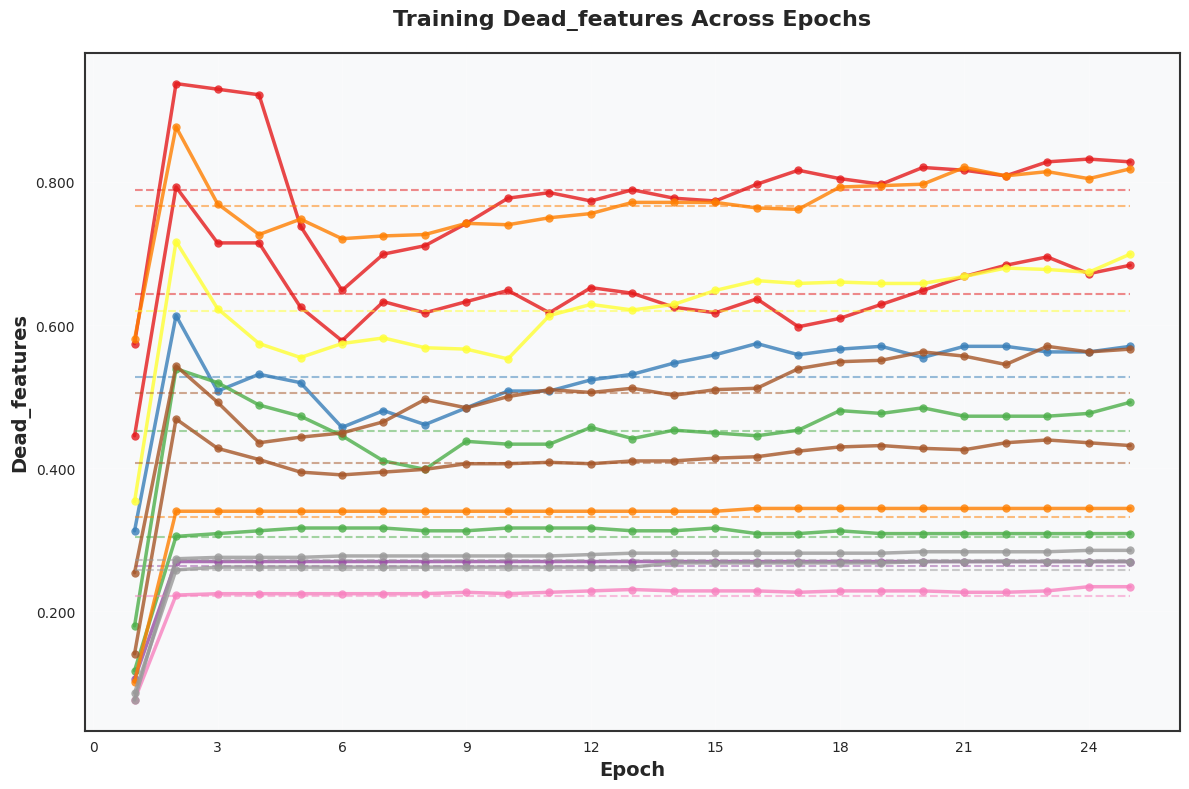

In [7]:
plotter(logs_topk, 'dead_features')

## Topk Reanimate

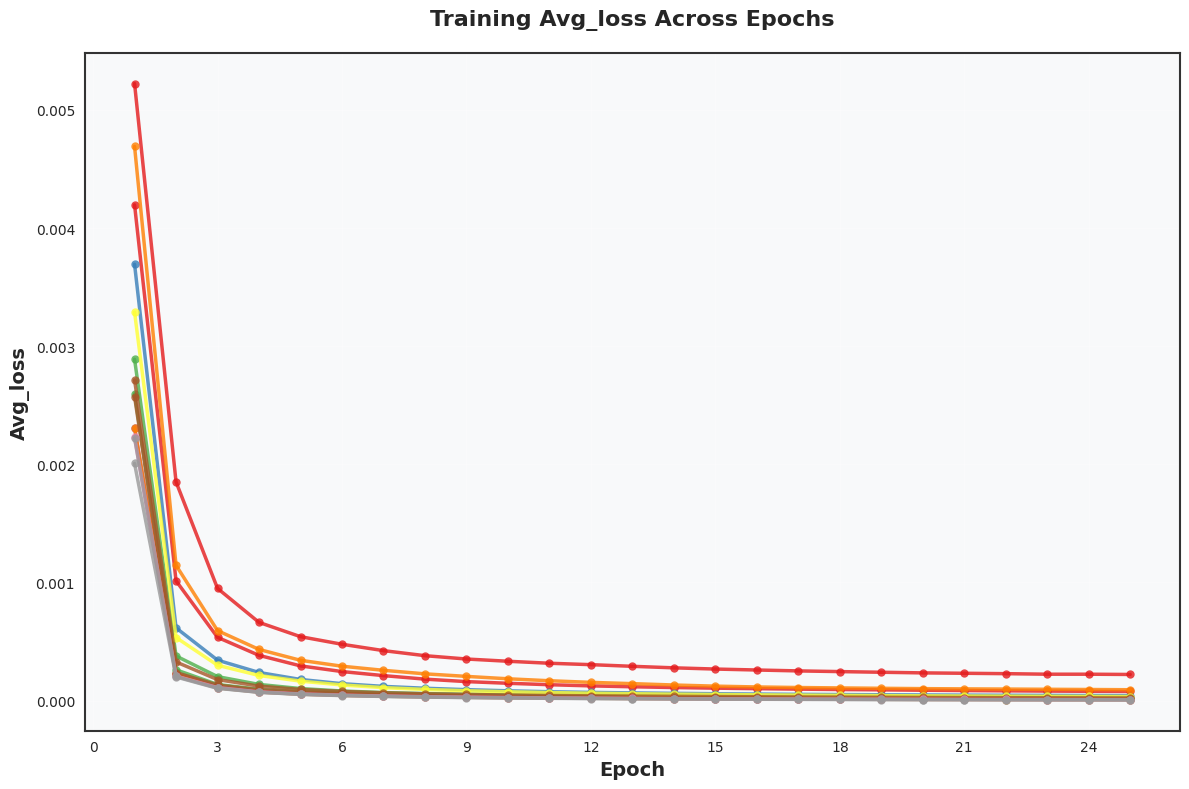

In [9]:
plotter(logs_topk_reanim, 'avg_loss')

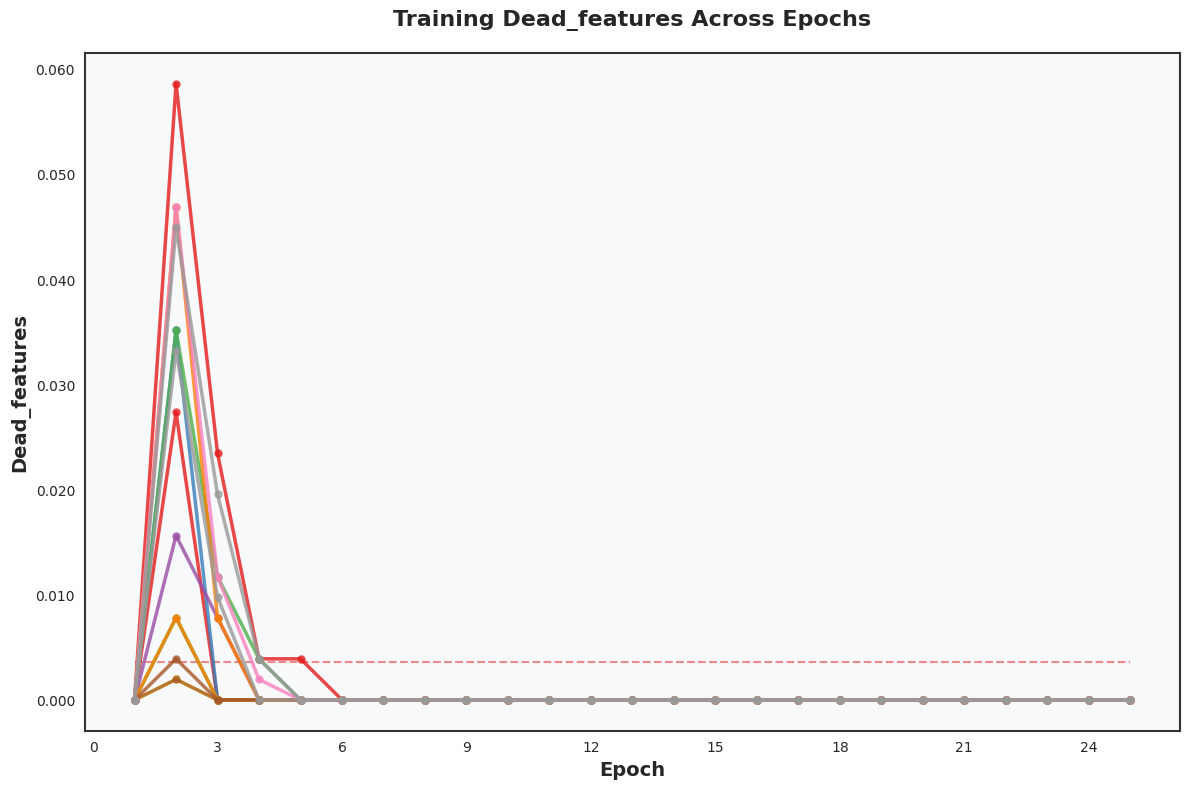

In [10]:
plotter(logs_topk_reanim, 'dead_features')